# Map Uniprot IDs to gene symbols

In [74]:
import polars as pl
import pandas as pd
from biomart import BiomartServer

In [75]:
ids = pl.read_csv("./inputs/proteomics_data/protein_metadata.txt", separator="\t")
uniprot_ids = ids.select("uniprot_id").to_series().unique().to_list()

In [76]:
# Connect to the BioMart server and dataset
server = BiomartServer("http://www.ensembl.org/biomart/martservice")
mart = server.datasets['hsapiens_gene_ensembl']

# Define the attributes to retrieve
attributes = [
    'uniprotswissprot',     # UniProt ID (SwissProt)
    'external_gene_name',   # Gene symbol
    'ensembl_gene_id'       # Optional: Ensembl Gene ID
]

batch_size = 100
results = []

# Query BioMart in batches
for i in range(0, len(uniprot_ids), batch_size):
    batch = uniprot_ids[i:i + batch_size]
    
    filters = {
        'uniprotswissprot': batch
    }
    
    try:
        response = mart.search({"attributes": attributes, "filters": filters})
        data = [line.decode("utf-8").split("\t") for line in response.iter_lines()]
        df_batch = pl.DataFrame(pd.DataFrame(data))
        df_batch.columns = ["uniprot_id", "gene_symbol", "ensembl_gene_id"]
        results.append(df_batch)
    except Exception as e:
        print(f"Batch {i//batch_size + 1} failed: {e}")

# Combine all results
all_gene_symbols = pl.concat(results)

In [77]:
unique_gene_symbols = all_gene_symbols.unique(subset=["uniprot_id"], keep="first")
ids = ids.join(unique_gene_symbols, on="uniprot_id", how="left")
ids.write_csv("./outputs/gene_ids.csv")

# NOTE: we looked for interesting patterns in these proteins by uploading them to enrichr

## Get subcellular locations from Human Protein Atlas

In [78]:
hpa = pl.DataFrame(pd.read_table("./inputs/external_annotations/hpa_subcellular_location.tsv", sep="\t")).rename({
    "Gene": "ensembl_gene_id"
})
hpa = ids.join(hpa, on="ensembl_gene_id", how="left")
hpa.write_csv("./outputs/proteins_hpa.csv")

## Determine which proteins are expressed in HepaRG

In [79]:
# Process data
counts = pl.read_csv("./inputs/external_transcriptomics/GSE288929_httr_atlas_counts.csv")

probes = pl.read_csv("./inputs/external_transcriptomics/GSE288929_httr_atlas_probes.csv").select([
    "Probe_Name", "Ensembl_Gene"
]).rename({"Ensembl_Gene": "ensembl_gene_id", "Probe_Name": "Probe_ID"})

meta = pl.read_csv("./inputs/external_transcriptomics/metadata.csv").with_columns(
    pl.concat_str(["Plate", "Well"], separator="_").alias("Sample_ID")
)

# Annotate counts with Ensembl gene ids
counts = counts.join(probes, on="Probe_ID").drop("Probe_ID")

In [80]:
heparg_samples = meta.filter(pl.col("Cell_line") == "HepaRG").select("Sample_ID").to_series().to_list()

In [84]:
heparg_counts = counts.select(["ensembl_gene_id"] + heparg_samples).filter(~pl.col("ensembl_gene_id").is_null())
heparg_counts = heparg_counts.filter(pl.col("ensembl_gene_id").is_in(ids.select("ensembl_gene_id").to_series().to_list()))
heparg_counts = (
    heparg_counts.group_by("ensembl_gene_id")
    .mean()
    .sort("ensembl_gene_id")
)

In [82]:
heparg_stats = heparg_counts.unpivot(
    index = "ensembl_gene_id"
).group_by("ensembl_gene_id").agg([
    pl.col("value").mean().alias("mean_counts"),
    pl.col("value").std().alias("std_counts")
]).sort("mean_counts", descending=True)

heparg_stats.write_csv("./outputs/nomics_mrna_counts.csv")

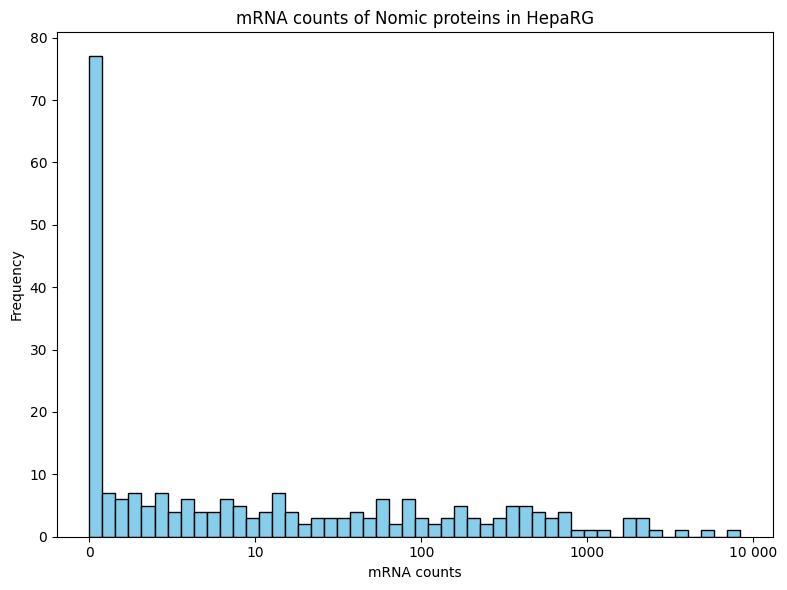

In [83]:
import matplotlib.pyplot as plt
import numpy as np

tick_dict = {
    0: '0',
    1: '10',
    2: '100',
    3: '1000',
    4: '10 000',
}

log10_counts = np.log10(heparg_stats.select("mean_counts").to_numpy() + 1)
plt.figure(figsize=(8, 6))
plt.hist(log10_counts, bins=50, color="skyblue", edgecolor="black")
plt.xlabel("mRNA counts")
plt.ylabel("Frequency")
plt.title("mRNA counts of Nomic proteins in HepaRG")

current_ticks = plt.gca().get_xticks()
major_ticks = [tick for tick in current_ticks if tick in tick_dict]
plt.xticks(major_ticks, [tick_dict.get(int(tick), str(int(tick))) for tick in major_ticks])

plt.tight_layout()
plt.show()